In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import folium
from folium.plugins import HeatMap
import shapefile as shp
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm import tqdm
from matplotlib import cm
import geopandas as gpd

In [2]:
# colormap = cm.get_cmap(name="inferno", lut=None)
# colormap.N

In [6]:
# read in data files
train = pd.read_csv("Train.csv")
sub = pd.read_csv("SampleSubmission.csv")
shapes = gpd.read_file("./mwi_admbnda_adm3_nso_20181016.shp")

In [8]:
# some preprocessing
train2015 = train.drop([col for col in train.columns if '2019' in col],axis=1)
precip = [i for i in range(1,18)]
train2015.columns = ['X','Y','target','elevation']+precip+['LC_Type1_mode','id']
train2015['sum'] = train2015[precip].apply(lambda x: x.sum(),axis=1)
train2015['mean'] = train2015[precip].apply(lambda x: x.mean(),axis=1)
max_flood = train2015[train2015.target==1]
no_flood = train2015[train2015.target==0]

In [9]:
# function to match Square_ID to administrative region provided in shape file 
def encodePolygon(points, polygons):
    numPoints = len(points)
    numPolygons = len(polygons)
    for idx, point in tqdm(enumerate(points)):
        row = np.zeros(numPolygons)
        for idx2, polygon in enumerate(polygons):
            if polygon.contains(point):
                row[idx2] = 1
                break
        if idx == 0:
            matrix = row
        else:
            matrix = np.vstack((matrix,row))
    return matrix.transpose()    

In [17]:
# match Square_ID to administrative region and calculate flooding extent for each region
points = []
for point in zip(train2015.X.values,train2015.Y.values):
    points.append(Point(point[0],point[1]))
polygons = shapes.geometry.values
    
point_polygon_matrix = encodePolygon(points,polygons)
target = train2015.target.values
flooded_polygons = point_polygon_matrix.dot(target.transpose())
shapes = shapes.assign(flood=flooded_polygons)

16466it [01:45, 155.42it/s]


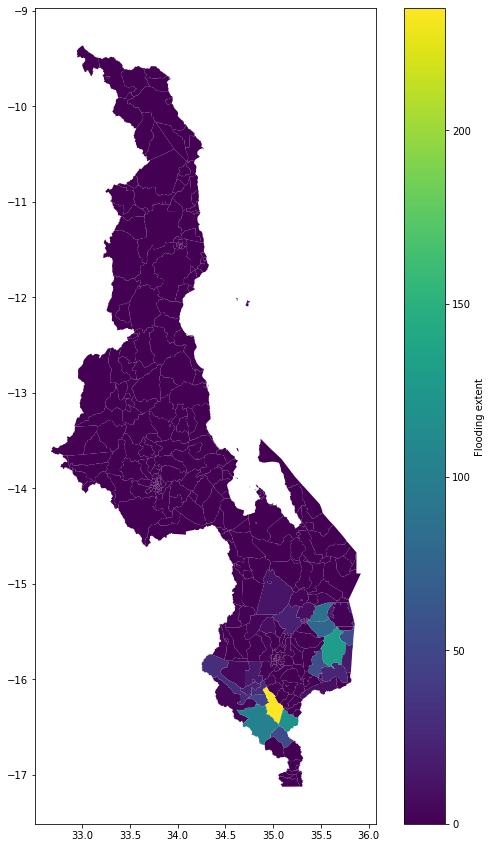

In [23]:
# plot Malawi flood map
fig, ax = plt.subplots(1, 1,figsize=(10,15))
shapes.plot(column='flood',ax=ax,legend=True,legend_kwds={'label':'Flooding extent','orientation':'vertical'})


In [65]:
# look into how the most flooded regions are distributed across the country
malawi_coord = [-13.2543, 34.3015]
base_map = folium.Map(location=malawi_coord, control_scale=True, zoom_start = 6)
max_flood_coords = []
max_flood_lat = list(max_flood.Y.values)
max_flood_lng = list(max_flood.X.values)
for coord in zip(max_flood_lat,max_flood_lng):
    max_flood_coords.append(coord)
HeatMap(max_flood_coords,radius=5,blur=2).add_to(base_map)
base_map